In [189]:
import pickle
import numpy as np
import os
import tensorflow as tf
import time
import h5py
import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [5]:
#Load indices and the itoword dictionary
word_dict = open("word_dict.pkl", "rb")
word_dict = pickle.load(word_dict)

In [6]:
print(len(word_dict))
print(word_dict[1])
print(word_dict[2])

1004
x_START_
x_END_


In [16]:
ROOT_DIR = os.getcwd()
print('ROOT:', ROOT_DIR)
EMBED_DIR = os.path.join(ROOT_DIR, 'attention_embed')
print('embeddings:', EMBED_DIR)
CAPTION_DIR = os.path.join(ROOT_DIR, 'attention_captions')
print('captions:', CAPTION_DIR)
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')
print('images:', IMAGE_DIR)
MODEL_DIR = os.path.join(ROOT_DIR, 'attention_models')
print('models:', MODEL_DIR)
GLOVE_DIR = os.path.join(ROOT_DIR, 'glove.6B.200d.txt')
print('glove:', GLOVE_DIR)

ROOT: C:\Users\ayhok\Desktop\EEE443 Project
embeddings: C:\Users\ayhok\Desktop\EEE443 Project\attention_embed
captions: C:\Users\ayhok\Desktop\EEE443 Project\attention_captions
images: C:\Users\ayhok\Desktop\EEE443 Project\images
models: C:\Users\ayhok\Desktop\EEE443 Project\attention_models
glove: C:\Users\ayhok\Desktop\EEE443 Project\glove.6B.200d.txt


In [8]:
sampleList = os.listdir(EMBED_DIR)
print(len(sampleList))
print(sampleList[0:10])

validImageList = [(int(s.replace('.npy', ''))) for s in sampleList]
print(validImageList[0:10])

trial = np.load(os.path.join(EMBED_DIR, sampleList[0]))
print('Shape of one embedding:', trial.shape)

73651
['1.npy', '10.npy', '100.npy', '1000.npy', '10000.npy', '10001.npy', '10002.npy', '10003.npy', '10004.npy', '10006.npy']
[1, 10, 100, 1000, 10000, 10001, 10002, 10003, 10004, 10006]
Shape of one embedding: (1, 8, 8, 2048)


In [9]:
f = h5py.File(ROOT_DIR + '\\eee443_project_dataset_train.h5', 'r')
print(f.keys())
trainImid = f['train_imid'].value
print(trainImid)

trainCap = f['train_cap'].value
print(trainCap[0])

<KeysViewHDF5 ['train_cap', 'train_imid', 'train_ims', 'train_url', 'word_code']>
[53315 21549 53315 ... 37874  5087 28657]
[  1   4 142 510  10 667 415 277  58   2   0   0   0   0   0   0   0]


c:\users\ayhok\appdata\local\programs\python\python37\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [10]:
#extract captions for existing images
def retreive_capt_id(image_id ,imid_list, cap_list):
    capList = []
    idList = []
    caps = np.where(imid_list == image_id)[0]
    caps = cap_list[caps]
    for cap in caps:
        capList.append(cap)
        idList.append(image_id)
    return capList, idList

def retreive_capt_batch(image_id_list ,imid_list, cap_list):
    idList = []
    captionsList = []
    for image_id in image_id_list:
        caps, ids = retreive_capt_id(image_id,imid_list,cap_list)
        captionsList.extend(caps)
        idList.extend(ids)
    return np.asarray(captionsList), np.asarray(idList)


In [11]:
captionsList, captionIDList = retreive_capt_batch(validImageList,trainImid, trainCap)
print(captionsList.shape)
print(captionIDList.shape)

print(captionsList[0:15,:])
print(captionIDList[0:15])

if not os.path.exists(CAPTION_DIR):
    os.mkdir(CAPTION_DIR)
    np.save(os.path.join(CAPTION_DIR, 'captionsAttention.npy'), captionsList)
    np.save(os.path.join(CAPTION_DIR, 'captionsIDAttention.npy'), captionIDList)


(356052, 17)
(356052,)
[[  1   4 341  54 592  99 506  10 287   2   0   0   0   0   0   0   0]
 [  1   4 249 341  24   9   3   3 165 287   2   0   0   0   0   0   0]
 [  1   4 249  24   9   4 581   5  33   6  31 400   9  99 287   2   0]
 [  1   4 249  24   9   4 497   3   8   7 222  80   3   2   0   0   0]
 [  1   4  24  11   3   9  99 287   9  60   3   2   0   0   0   0   0]
 [  1  16  19   8   4  61 125 107  72  18  15   3   2   0   0   0   0]
 [  1   4  12   8   4   3  10 254   3  93   4 185   2   0   0   0   0]
 [  1   4  12   8   4  61 562  72  32  18   4 238   6 328   2   0   0]
 [  1   4  12   9   4   3  10   4  60 189  11 460  30  61   2   0   0]
 [  1   4  28 507 143   7 185   6   4  61 125   2   0   0   0   0   0]
 [  1   4 592 831  11   3   9   3 704  10   3 400  50   3 746 669   2]
 [  1   4  58   9   3 704  10 715   3   2   0   0   0   0   0   0   0]
 [  1 704  10   3   9   3   3   8   4 509 831   2   0   0   0   0   0]
 [  1   4  77   6   3 614  13   4 137   8   4 831   2 

In [12]:
#Load cached caption-id matched lists
captionList = np.load(os.path.join(CAPTION_DIR,'captionsAttention.npy'))
captionIDList = np.load(os.path.join(CAPTION_DIR,'captionsIDAttention.npy'))
print(captionList.shape, captionIDList.shape)

#split train and test
img_name_train, img_name_val, cap_train, cap_val = train_test_split(captionIDList, captionList,test_size=0.1, random_state=0)
print('Train ImIDs and Captions', img_name_train.shape, cap_train.shape)
print('Val ImIDs and Captions', img_name_val.shape, cap_val.shape)

(356052, 17) (356052,)
Train ImIDs and Captions (320446,) (320446, 17)
Val ImIDs and Captions (35606,) (35606, 17)


In [27]:
#Hyperparameters
BATCH_SIZE = 487
#for shuffling
BUFFER_SIZE = 1000
#using glove6b/200 
embedding_dim = 200
#unit num for attention
units = 512

vocab_size = len(word_dict)
batch_num = int(len(img_name_train)/BATCH_SIZE)

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

def map_func(img_name, cap):
    #load feature
    embed_tensor = np.load(os.path.join(EMBED_DIR, str(img_name)+'.npy'))
    #reshape the 1x8x8x2048 tensor to 64x2048
    n,x,y,z = embed_tensor.shape
    embed_tensor = embed_tensor.reshape((x*y,z))
    return embed_tensor, cap

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [19]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open(GLOVE_DIR, encoding="utf-8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

400000it [00:22, 18000.71it/s]


In [47]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for i, word in word_dict.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        word_x = str.lower(word.replace('x',''))
        embedding_vector = embeddings_index.get(word_x)
        if embedding_vector is None:
            print(word_x)
            embedding_vector = np.zeros((1,embedding_dim))
        embedding_matrix[i] = embedding_vector

_null_
_end_
_start_
_unk_


In [48]:
print(embedding_matrix.shape)
print(embedding_matrix)

(1004, 200)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.0029923  -0.79718     0.0061861  ...  0.78188002 -0.52678001
   0.34862   ]
 [ 0.052208    0.40889999  0.058823   ... -0.33627    -0.021329
  -0.001735  ]
 [ 0.60191    -0.63353997  0.17701    ...  0.75579    -0.39802
  -0.40033999]]


In [212]:
class SoftAttention(tf.keras.Model):
    def __init__(self, fcDim):
        super(SoftAttention, self).__init__()
        self.featLayer = tf.keras.layers.Dense(fcDim)
        self.hidLayer = tf.keras.layers.Dense(fcDim)
        self.sumLayer = tf.keras.layers.Dense(1)
    
    #explained in report
    def call(self, features, hidden):
        hidden_exp = tf.expand_dims(hidden, 1)

        sumLayers = self.featLayer(features) + self.hidLayer(hidden_exp)
        relevanceScore = tf.nn.tanh(sumLayers)
        
        attWeights = tf.nn.softmax(self.sumLayer(relevanceScore), axis=1)
        #ottend over features by estimating expectation
        contextVec = attWeights * features
        contextVec = tf.reduce_sum(contextVec, axis=1)

        return contextVec, attWeights

In [213]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.outLayer = tf.keras.layers.Dense(embedding_dim)
    def call(self, x):
        x = self.outLayer(x)
        x = tf.nn.relu(x)
        return x

In [215]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.attention = SoftAttention(self.units)
        #use glove vectors as weights
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix])
        self.gru = tf.keras.layers.GRU(self.units, recurrent_initializer='glorot_uniform', return_sequences=True, return_state=True)
        self.fcHid = tf.keras.layers.Dense(self.units)
        self.fcOut = tf.keras.layers.Dense(vocab_size)


    def call(self, x, features, hidden):
        contextVec, attWeights = self.attention(features, hidden)
        # extract embedding
        x = self.embedding(x)
        temp = tf.expand_dims(contextVec, 1)
        #concat the enbedding with context vector
        x = tf.concat([temp, x], axis=-1)        
        # pass the concatenated vector gru
        output, state = self.gru(x)
        x = self.fcHid(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fcOut(x)
        return x, state, attWeights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [60]:
encoder = Encoder(embedding_dim)
decoder = Decoder(embedding_dim, units, vocab_size)

In [61]:
lossFcn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def customLoss(real, pred):
    lossVal = lossFcn(real, pred)
    mask = tf.cast(tf.math.logical_not(tf.math.equal(real, 0)),  dtype=loss_.dtype)
    lossVal *= mask
    return tf.reduce_mean(lossVal)

In [94]:
lossList = []
optim = tf.keras.optimizers.Adam()

@tf.function
def trainingStep(img_embed, caption):
    loss = 0
    #reset hidden state
    hidden = decoder.reset_state(batch_size=caption.shape[0])
    
    #In our data, this corresponds to x_START_
    START_INDEX = 1
    dec_input = tf.expand_dims([START_INDEX] * caption.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #pass through encoder
        features = encoder(img_embed)
        #train rnn with teacher forcing (recursive)
        for i in range(1, caption.shape[1]):
          # pass through decoder 
            pred, hidden, _ = decoder(dec_input, features, hidden)
            loss += customLoss(caption[:, i], pred)
            dec_input = tf.expand_dims(caption[:, i], 1)

    total_loss = (loss / int(caption.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optim.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [63]:
EPOCHS = 40

for epoch in range(EPOCHS):
    start_time = time.time()
    running_loss = 0

    for (batch, (embed_tensor, caption)) in enumerate(dataset):
        running_loss, total_loss_t = trainingStep(embed_tensor, caption)
        total_loss += total_loss_t

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.8f}'.format( epoch + 1, batch, batch_loss.numpy() / int(caption.shape[1])))
    lossList.append(total_loss / batch_num)
    dur = time.time() - start_time
    #report epoch err and time
    print ('Epoch {} CE Error {:.8f}'.format(epoch + 1, total_loss/batch_num))
    print ('Duration {} seconds\n'.format(dur)

Epoch 1 Batch 0 Loss 4.64471795
Epoch 1 Batch 100 Loss 2.19899256
Epoch 1 Batch 200 Loss 2.10301366
Epoch 1 Batch 300 Loss 2.06719634
Epoch 1 Batch 400 Loss 1.87322022
Epoch 1 Batch 500 Loss 1.92223515
Epoch 1 Batch 600 Loss 1.89027584
Epoch 1 Loss 2.08576417
Time taken for 1 epoch 411.7208333015442 sec

Epoch 2 Batch 0 Loss 1.90327656
Epoch 2 Batch 100 Loss 1.83829285
Epoch 2 Batch 200 Loss 1.83233542
Epoch 2 Batch 300 Loss 1.81990377
Epoch 2 Batch 400 Loss 1.76059689
Epoch 2 Batch 500 Loss 1.77013577
Epoch 2 Batch 600 Loss 1.80235111
Epoch 2 Loss 1.81361663
Time taken for 1 epoch 390.005624294281 sec

Epoch 3 Batch 0 Loss 1.80245803
Epoch 3 Batch 100 Loss 1.75323441
Epoch 3 Batch 200 Loss 1.77236983
Epoch 3 Batch 300 Loss 1.76254878
Epoch 3 Batch 400 Loss 1.69947344
Epoch 3 Batch 500 Loss 1.71575838
Epoch 3 Batch 600 Loss 1.73167655
Epoch 3 Loss 1.74292827
Time taken for 1 epoch 386.62268829345703 sec

Epoch 4 Batch 0 Loss 1.74665395
Epoch 4 Batch 100 Loss 1.73418887
Epoch 4 Batch 20

In [199]:
def print_pred(imgID):
    print('-----------------------------\nSample ID', imgID)
    img = PIL.Image.open(os.path.join(IMAGE_DIR,str(imgID)))
    plt.imshow(img)
    plt.show()
    
    print('\nCaptions:')
    captions = retreive_capt_id(imgID, trainImid, trainCap)[0]
    captionsStr = []
    for caption in captions:
        capStr = ''
        cap = []
        for word in caption:
            if(word != 2 and word != 1 and word != 0):
                capStr += word_dict[word] + ' '
                cap.append(word_dict[word])
        print(capStr)
        captionsStr.append(cap)
                
    embed = np.load(os.path.join(EMBED_DIR, str(imgID)+'.npy'))
    pred = evaluate(embed)
    predLst = []
    capStr = '\nPrediction:'
    for word in pred:
        if(word != 2 and word != 1 and word != 0):
            capStr += word_dict[word] + ' '
            predLst.append(word_dict[word])
    
    print('\nBLEU Score', sentence_bleu(captionsStr,predLst))
    print(capStr)

-----------------------------
Sample ID 44433


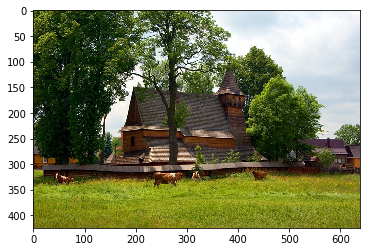


Captions:
a brown wooden house with a lush green yard with lots of trees 
cows x_UNK_ in a field x_UNK_ a house 
a house that is surrounded by a lot of trees 
cows in a field grazing near a house 
a farm house surrounded by cattle and tall trees 

BLEU Score 8.909555824566607e-155

Prediction:a large x_UNK_ x_UNK_ x_UNK_ in the middle of a field 
-----------------------------
Sample ID 74504


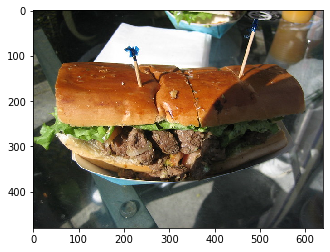


Captions:
a large x_UNK_ x_UNK_ sandwich sitting in a paper basket on a glass x_UNK_ 
the meal is prepared and ready to be eaten 
a sandwich sitting on paper plate on a glass table 
a x_UNK_ sandwich with onions and lettuce on a x_UNK_ bun 
a large long sandwich with x_UNK_ x_UNK_ on a table 

BLEU Score 1.0651020219741284e-154

Prediction:a sandwich on a plate with a x_UNK_ 
-----------------------------
Sample ID 78787


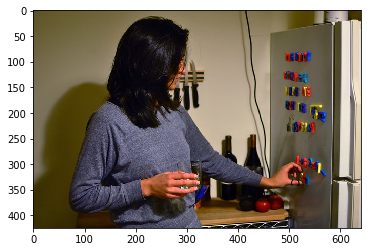


Captions:
a young x_UNK_ woman x_UNK_ the x_UNK_ on the side of a fridge 
a woman x_UNK_ x_UNK_ x_UNK_ on a fridge 
a woman x_UNK_ colorful refrigerator x_UNK_ in a kitchen 
a woman x_UNK_ x_UNK_ x_UNK_ on a fridge 
a woman playing with x_UNK_ on a refrigerator 

BLEU Score 1.177954727398402e-154

Prediction:a woman in a x_UNK_ x_UNK_ a x_UNK_ x_UNK_ 
-----------------------------
Sample ID 9343


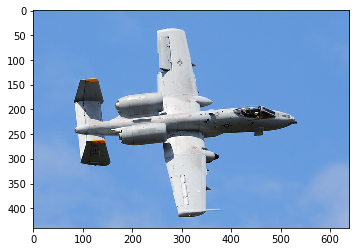


Captions:
a jet flying through the clear blue sky 
a large x_UNK_ jet flying through he blue sky on its side 
a jet fighter plane making a x_UNK_ x_UNK_ 
that is an x_UNK_ x_UNK_ airplane flying across the blue sky 
a large military jet flying side x_UNK_ in the air 

BLEU Score 4.583829695130767e-78

Prediction:a x_UNK_ truck with a x_UNK_ x_UNK_ on it 
-----------------------------
Sample ID 5978


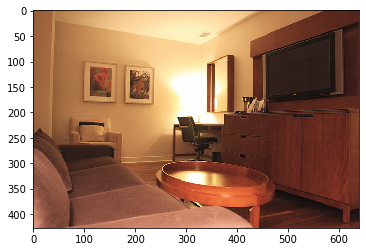


Captions:
a living room with tv x_UNK_ into a cabinet 
a work station and couch in a hotel room 
living room x_UNK_ up with sofa and television 
the television is in its stand on the wall 

BLEU Score 1.619863157690489e-231

Prediction:a bathroom with a sink and a x_UNK_ 
-----------------------------
Sample ID 52800


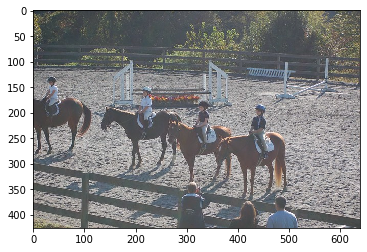


Captions:
a group of people on horses in a field 
a group of young x_UNK_ x_UNK_ on their horses 
the four kids are sitting on horses xWhile people watch 
four young women sitting on top of horses in a horse x_UNK_ 
several children are on horses during a x_UNK_ 

BLEU Score 0.42728700639623407

Prediction:a group of people sitting on a bench 
-----------------------------
Sample ID 11315


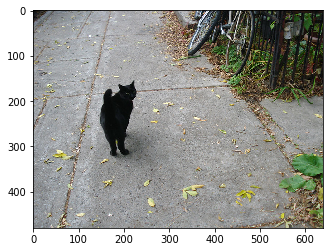


Captions:
a black cat that is standing on a sidewalk 
a black cat x_UNK_ around on a sidewalk 
a black cat looking back with x_UNK_ x_UNK_ on a sidewalk 
a cat walks on a sidewalk near some bikes 
the black cat is standing alone on the sidewalk 

BLEU Score 7.401184483348608e-155

Prediction:a black and white photo of a man on a snowy slope 
-----------------------------
Sample ID 3138


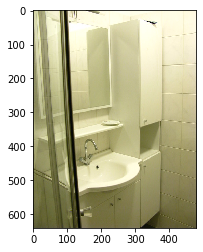


Captions:
a white bathroom with a sink and mirror next to a shower 
a white sink in a bathroom next to a mirror 
a sink sitting under a mirror and near some x_UNK_ 
a bathroom with a glass door and a sink and mirror 
new x_UNK_ white bathroom x_UNK_ mirror and cabinets 

BLEU Score 0.5169731539571706

Prediction:a bathroom with a white sink and a shower 
-----------------------------
Sample ID 51848


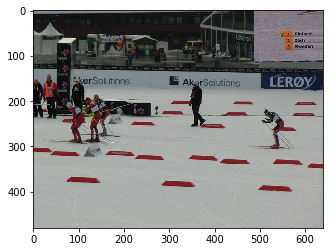


Captions:
a group of people skiing in x_UNK_ snow 
cross country skiers race through a skiing event 
multiple skiers ski in the snow in what x_UNK_ to be a x_UNK_ 
a group of people on skis between red x_UNK_ 
x_UNK_ skiers wearing red and white in a skiing x_UNK_ 

BLEU Score 0.2907153684841096

Prediction:a group of people are skiing on a snowy day 
-----------------------------
Sample ID 29298


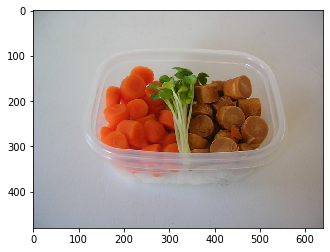


Captions:
a plastic container filled with meat carrots and x_UNK_ 
a container with cut carrots and cut x_UNK_ 
cut up vegetables in an open plastic x_UNK_ container 
meat and vegetable items in small plastic container 
there are three different kinds of vegetables in the container 

BLEU Score 1.2882297539194154e-231

Prediction:a x_UNK_ x_UNK_ x_UNK_ x_UNK_ on a bed 
-----------------------------
Sample ID 82749


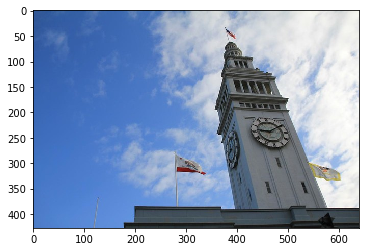


Captions:
a large white clock tower under a cloudy blue sky 
clock tower with three x_UNK_ x_UNK_ under blue skies 
a x_UNK_ clock tower with three x_UNK_ x_UNK_ into the sky 
a big clock tower with two x_UNK_ on a clear day 
white clock tower with three x_UNK_ on top 

BLEU Score 6.391479844322342e-78

Prediction:a large clock tower with a x_UNK_ x_UNK_ on it 
-----------------------------
Sample ID 78189


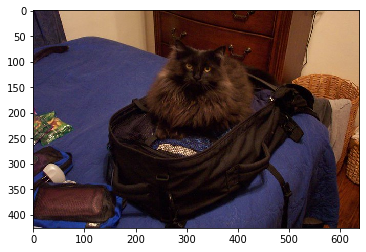


Captions:
a x_UNK_ of a black cat in a suitcase on top of a bed 
a x_UNK_ black cat lays in a black suitcase 
a x_UNK_ black cat laying on a suitcase 
a cat sits in a suitcase on a bed 
a black cat sitting in a bag on a bed 

BLEU Score 7.051402097550211e-78

Prediction:a cat is laying on a bed with a x_UNK_ 
-----------------------------
Sample ID 77997


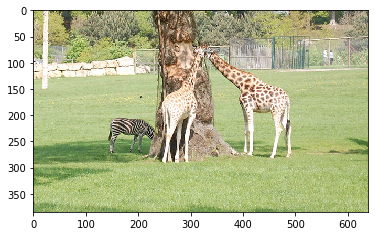


Captions:
two giraffes and a small zebra standing under a large tree 
two giraffes are standing by a tree and eating 
a couple of giraffes that are standing near a tree 
two giraffes and zebra with tree and grassy field 
two giraffes and a zebra by a tree 

BLEU Score 0.42728700639623407

Prediction:two giraffes are standing in a grassy field 
-----------------------------
Sample ID 73088


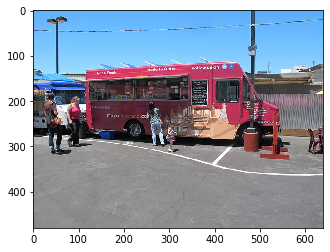


Captions:
a red food truck with a woman looking at the x_UNK_ 
people x_UNK_ and x_UNK_ at a red food truck 
a big red food x_UNK_ truck with x_UNK_ 
several people are looking at the food truck 
a few people are near the made to x_UNK_ bus 

BLEU Score 1.2778269941762074e-231

Prediction:a x_UNK_ x_UNK_ x_UNK_ x_UNK_ x_UNK_ x_UNK_ 
-----------------------------
Sample ID 33493


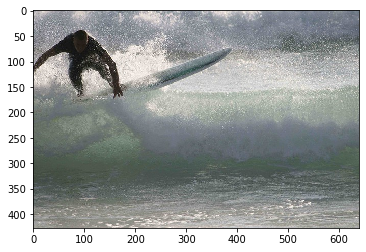


Captions:
a surfer rides the x_UNK_ of an ocean wave 
guy gets x_UNK_ low on his surfboard as he x_UNK_ the wild wave 
a guy is surfing in the ocean 
x_UNK_ surf x_UNK_ a man on a surfboard 
a person on a surf board on top of a wave 

BLEU Score 0.5

Prediction:a person on a surfboard riding a wave 
-----------------------------
Sample ID 82102


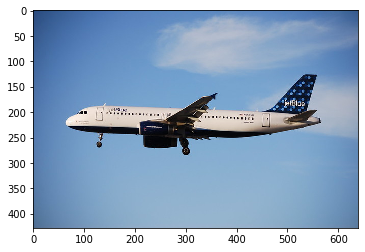


Captions:
a large x_UNK_ flying through a blue cloudy sky 
a blue and white jet flying in a blue sky 
an airplane with the landing gear x_UNK_ flying in the sky 
a very large commercial plane flying in blue skies 
a white airplane with a x_UNK_ x_UNK_ x_UNK_ in the air 

BLEU Score 0.4671379777282001

Prediction:a large passenger jet flying through a blue sky 
-----------------------------
Sample ID 21544


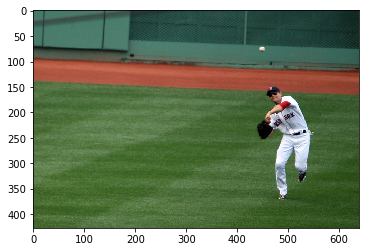


Captions:
a man in a baseball uniform with a glove near a ball 
the man is throwing the baseball during the game 
a baseball player wearing a baseball glove catching a ball 
a baseball player on a field throwing a baseball 
a baseball player that is throwing a ball 

BLEU Score 7.803659209895733e-78

Prediction:a baseball player is standing on a field 
-----------------------------
Sample ID 43736


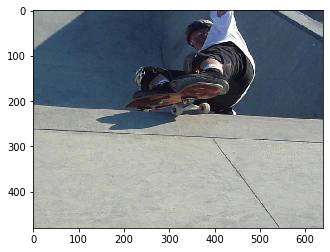


Captions:
a person x_UNK_ down a ramp on a skateboard 
there is a male skateboarder that x_UNK_ to have x_UNK_ 
a man skating at the edge of the stone 
a man is skateboarding in a skate park 
a man is skateboarding on the edge of a building 

BLEU Score 1.254338396921439e-154

Prediction:a man riding a skateboard on a ramp 
-----------------------------
Sample ID 65930


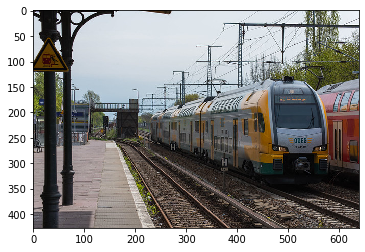


Captions:
a train that is x_UNK_ the tracks next to another train 
a passenger train that is driving down the tracks 
a couple of trains parked next to each other 
a x_UNK_ train in a x_UNK_ country is ready xFor passengers 
two x_UNK_ trains sitting on tracks next to a station 

BLEU Score 7.1958300848837144e-155

Prediction:a train on a track near a train 
-----------------------------
Sample ID 35239


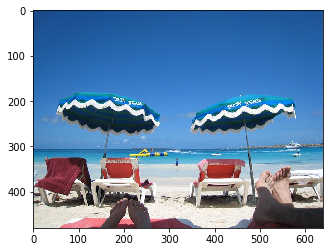


Captions:
a beach filled with lawn chairs and blue and white umbrellas 
people are laying on beach chairs in the shade 
x_UNK_ x_UNK_ sit in front of the beach on a clear day 
the feet of two people on a beach with chairs and umbrellas 
people are sitting under umbrellas on the beach 

BLEU Score 1.4875195904069663e-231

Prediction:a large group of people standing around a x_UNK_ 


In [210]:
no_samples = 20
np.random.seed(22)
test_indices = np.random.permutation(len(img_name_train))[0:no_samples]
for ind in test_indices:
    print_pred(img_name_val[ind])

In [140]:
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

encoder.save(os.path.join(MODEL_DIR, 'encoder_attention_glove'))
#decoder.save_weights(os.path.join(MODEL_DIR, 'decoder_attention_glove'), )

W0112 03:00:50.775379 28056 save_impl.py:84] Skipping full serialization of Keras layer <tensorflow.python.keras.saving.saved_model.load.Dense object at 0x00000224359F4550>, because it is not built.


In [214]:
encoderlol = Encoder(embedding_dim)
encoderlol.build(input_shape=(64,2048))
print(encoderlol.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             multiple                  409800    
Total params: 409,800
Trainable params: 409,800
Non-trainable params: 0
_________________________________________________________________
None


In [216]:
print(decoder.summary())

Model: "rnn__decoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  200800    
_________________________________________________________________
gru_1 (GRU)                  multiple                  1403904   
_________________________________________________________________
dense_10 (Dense)             multiple                  262656    
_________________________________________________________________
dense_11 (Dense)             multiple                  515052    
_________________________________________________________________
bahdanau_attention_1 (Bahdan multiple                  366081    
Total params: 2,748,493
Trainable params: 2,748,493
Non-trainable params: 0
_________________________________________________________________
None
